<a href="https://colab.research.google.com/github/acoiman/searching_scientific_articles/blob/main/Searching_on_Google_Scholar_Scopus_PubMed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Searching on Google Scholar, Scopus and Pubmed From 2013 to 2022 to write a systematic review article about asthma, allergic rhinitis, air quality, and remote sensing.**

First, we will outline our main research question that will be used to filter our results from Google Scholar, Scopus, and PubMed.

In [6]:
!pip install schemdraw --quiet
!pip install dtale --quiet
!pip install scholarly --quiet
!pip install pydrive --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 642.7/642.7 kB 31.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.3/229.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [4]:
import schemdraw
from schemdraw.flow import *

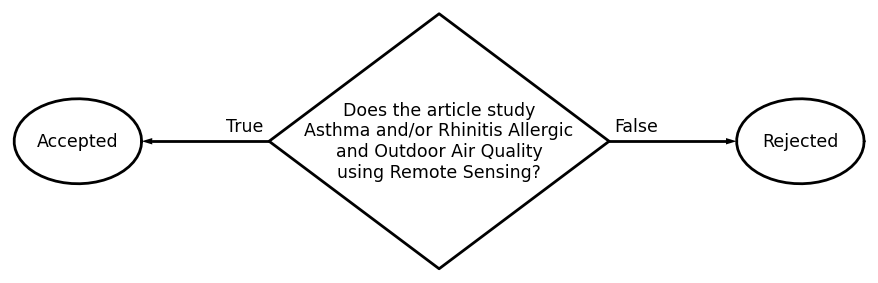

In [ ]:
with schemdraw.Drawing() as d:

    d+= (decision := Decision(w = 8, h= 6,
                              E="False",
                              W='True'
                              ).label("Does the article study\nAsthma and/or Rhinitis Allergic\nand Outdoor Air Quality\nusing Remote Sensing?"))
    # if False arrow right from East of decision box
    d+= Arrow().right(d.unit).at(decision.E)
    # end-rejected
    d+= (end := Ellipse().label("Rejected"))
    # if True arrow left from West of decision box
    d+= Arrow().left(d.unit).at(decision.W)
    # end-accepted
    d+= (end := Ellipse().label("Accepted"))


Based on this question we will build the following search terms for Google Scholar, Scopus, and PubMed from 2013 to 2022.

- remote sensing AND air quality: both terms are mandatory in the result.
- asthma  OR allergic rhinitis: any of this terms in the result (enclosing both terms inside brackets gives the same result)

Exclusion terms:
- indoor
- COVID
- coronavirus
- SARS

Period:
- 2013-2022


### **Google Scholar**

asthma **and/or** allergic rhinitis **and** remote sensing **and** air quality in the **title** of the article

`intitle:asthma OR “allergic rhinitis”  AND “remote sensing” AND “air quality” -indoor -COVID -coronavirus -SARS`

This search string generates **172 results**

**Note:** Google Scholar does not allow searching inside the abstract and keywords

<hr style="border:1px solid gray">

### **Scopus**

asthma **and/or** allergic rhinitis **and** remote sensing **and** air quality in the **title, abstract, and keywords** of the article

`asthma OR “allergic rhinitis” AND "remote sensing" AND {air quality} AND NOT indoor OR COVID OR coronavirus OR SARS`

This search string generates **18 results**

<hr style="border:1px solid gray">

### **PubMed**

asthma **and/or** allergic rhinitis **and** remote sensing **and** air quality in the **title, and abstract** of the article

`(((((((asthma[Title/Abstract]) OR (allergic rhinitis[Title/Abstract])) AND (remote sensing[Title/Abstract])) AND (air quality[Title/Abstract])) NOT (indoor[Title/Abstract])) NOT (COVID[Title/Abstract])) NOT (coronavirus[Title/Abstract])) NOT (SARS[Title/Abstract])`

This search string generates **7 results**

**Note:** PubMed does not allow searching inside keywords.

<hr style="border:1px solid gray">

### **Total Number of Articles**

Based on the results we will start working with **197 papers**.

### **Methodology to get article data**

To get article data we will do the following:

1. Scrape Google Scholar to get a CSV file containing the following columns: Paper Title, Year, Author, Citation, Publication, Url of paper, and Abstract.

2. Get a CSV file from Scopus with the same column names.

3. Compare both datasets to detect duplicate titles.

4. Read the title and abstract of paper to answer the main research question. This reading will allow us to obtain a dataset of useful papers. Relevant papers will be used for writing our review article.  

## 1. Scraping Google Scholar

To scrape Google Scholar we will begin by importing all the required libraries.

In [7]:
import requests
from bs4 import BeautifulSoup
from scholarly import scholarly
import re
import dtale
import pandas as pd
from time import sleep
from urllib.parse import urlencode
from scholarly import scholarly, ProxyGenerator, MaxTriesExceededException
from getpass import getpass
import numpy as np
import matplotlib.pyplot as plt

The following function will allow us to set a proxy to scrape Google Scholar so that we can avoid bot detection and blocking.

In [ ]:
def set_proxy(proxy_type='NoProxy'):
    """Set a proxy for to scrape Google Scholar.

    Only `NoProxy`, `FreeProxy` and `ScraperAPI` have been tested.

    Parameters
    ----------
    proxy_type : str, optional
        Type of proxy to use. Case insensitive. Options are:
        `ScraperAPI`, `Luminati`, `FreeProxy`, `SingleProxy` and
        `NoProxy` (default).
    """
    if proxy_type.lower() == 'noproxy':
        print("Using no proxies!")
        return

    pg = ProxyGenerator()
    if proxy_type.lower() == 'scraperapi':
        payload = {'api_key': getpass("Enter your ScraperAPI"), }
        proxy_works = pg.ScraperAPI(payload['api_key'])
        if proxy_works is True:
            print("Using ScraperAPI!")
        elif proxy_works is False:
            print("ScraperAPI is not working!")
        elif proxy_works is None:
            print("Changes have not been reflected")
        else:
            print("God knows what is going on", proxy_works)
    elif proxy_type.lower() == 'luminati':
        pg.Luminati(getpass("Enter your Luminati username:"), getpass("Enter your Luminati password:"))
        print("Using Luminati!")
    elif proxy_type.lower() == 'singleproxy':
        proxy_address = getpass("Enter your proxy address:")
        pg.SingleProxy(proxy_address, proxy_address)
        print(f"Using SingleProxy: {proxy_address}")
    else:
        pg.FreeProxies()
        print("Using FreeProxy!")

    scholarly.use_proxy(pg)

Next, we will set a proxy to scrape Google Scholar so that we can avoid bot detection and blocking.

In [ ]:
# 037cc6348caa7ecb073bf21738d911a6
proxy_type = 'ScraperAPI'
set_proxy(proxy_type)

Enter your ScraperAPI··········
Using ScraperAPI!


The following function will allow us to scrape each URL resulting from our research terms. The results will be stored in a DataFrame containing all the above columns.

In [ ]:
def scrape_gs(url):

    # this function for the getting information of the web page
    def get_paperinfo(url):
        #download the page
        #response=requests.get(url,headers=headers)
        params = {'api_key': '037cc6348caa7ecb073bf21738d911a6', 'url': url}
        response = requests.get('http://api.scraperapi.com/', params=urlencode(params))

        #check successful response
        if response.status_code != 200:
            print('Status code:', response.status_code)
            raise Exception('Failed to fetch web page')

        #parse using beautiful soup
        paper_doc = BeautifulSoup(response.text,'html.parser')

        return paper_doc

    doc = get_paperinfo(url)

    def get_tags(doc):
        cite_tag = []

        paper_tag = doc.select('[data-lid]')

        for result in doc.select('.gs_ri'):
            cited_by = result.select_one('#gs_res_ccl_mid .gs_nph+ a')
            cite_tag.append(cited_by)

            #cite_tag = doc.select('[data-lid]')
            link_tag = doc.find_all('h3',{"class" : "gs_rt"})

            #author_tag = doc.select_one('.gs_scl:nth-child .gs_a  .gs_scl:nth-child .gs_a  .gs_scl:nth-child .gs_a  .gs_scl:nth-child .gs_a  .gs_scl:nth-child .gs_a  .gs_scl:nth-child .gs_a')
            author_tag = doc.find_all("div", {"class": "gs_a"})

        return paper_tag,cite_tag,link_tag,author_tag

    paper_tag,cite_tag,link_tag,author_tag = get_tags(doc)

    # it will return the title of the paper
    def get_papertitle(paper_tag):

        paper_names = []
        paper_names_clean = []

        for tag in paper_tag:
            paper_names.append(tag.select('h3')[0].get_text())

        for title in paper_names:
            clean = title.replace('[HTML][HTML] ', '').replace('\xa0…', '')
            paper_names_clean .append(clean)

        return paper_names_clean

    paper_title = get_papertitle(paper_tag)

    # it will return the number of citation of the paper
    def get_citecount(cite_tag):
        cite_count = []

        for i in cite_tag:
            cite = i.text
            if i is None or cite is None:  # if paper has no citatation then consider 0
                cite_count.append(0)
            else:
                tmp = re.search(r'\d+', cite) # its handle the None type object error and re use to remove the string " cited by " and return only integer value

                if tmp is None :
                    cite_count.append(0)
                else :
                    cite_count.append(int(tmp.group()))
        return cite_count

    paper_cite= get_citecount(cite_tag)

    # function for the getting link information
    def get_link(link_tag):

        links = []

        for i in range(len(link_tag)):
            try:
                links.append(link_tag[i].a['href'])
            except:
                links.append("no data")
        return links

    paper_link = get_link(link_tag)

    # function for the getting author , year and publication information
    def get_author_year_publi_info(author_tag):
        years = []
        publication = []
        authors = []
        lst_a_1 = []
        for i in range(len(author_tag)):
            authortag_text = (author_tag[i].text).split()

            # r'\d+\s+' \d is one o more digit followed by one o more sace
            if (re.search(r'\d+\s+', author_tag[i].text)) is None:
                years.append(np.nan)
            else:
                year = int(re.search(r'\d+\s+', author_tag[i].text).group())
                years.append(year)

            publication.append(authortag_text[-1])

        for i in range(len(author_tag)):
            authortag_text = (author_tag[i].text)
            lst_a_1.append(authortag_text)

        for item in lst_a_1:
            try:
                # extract until-
                hy = re.search('.+?(?=-)', item)
                gr = str(hy.group())
                authors.append(gr.replace('\xa0…', '').replace('\xa0', '').replace('…', ''))
            except:
                authors.append('no data')

        return years, publication, authors

    year, publication, author = get_author_year_publi_info(author_tag)

    # function to get abstract
    def get_abstract(title):
        paper_abs = []
        for item in title:
            try:
                search_query = scholarly.search_pubs(item)
                abst = next(search_query)
                paper_abs.append(abst.get('bib')['abstract'])
            except:
                 paper_abs.append('no data')
        return paper_abs

    paper_abs = get_abstract(paper_title)

    # creating final repository
    paper_repos_dict = {
        'Paper Title' : [],
        'Year' : [],
        'Author' : [],
        'Citation' : [],
        'Publication' : [],
        'Url of paper' : [],
        'Abstract': []
    }

    # adding information in repository
    def add_in_paper_repo(papername,year,author,cite,publi,link, abstract):
        paper_repos_dict['Paper Title'].extend(papername)
        paper_repos_dict['Year'].extend(year)
        paper_repos_dict['Author'].extend(author)
        paper_repos_dict['Citation'].extend(cite)
        paper_repos_dict['Publication'].extend(publi)
        paper_repos_dict['Url of paper'].extend(link)
        paper_repos_dict['Abstract'].extend(abstract)

        return pd.DataFrame(paper_repos_dict)

    df = add_in_paper_repo(paper_title ,year , author , paper_cite, publication, paper_link, paper_abs)

    return df

We will begin by scraping the first page.

In [ ]:
url_init = 'https://scholar.google.com/scholar?q=intitle%3Aasthma+OR+%E2%80%9Callergic+rhinitis%E2%80%9D+AND+%E2%80%9Cremote+sensing%E2%80%9D+AND+%E2%80%9Cair+quality%E2%80%9D+-indoor+-COVID+-coronavirus+-SARS&hl=en&as_sdt=0%2C5&as_ylo=2013&as_yhi=2022'

In [ ]:
# scrape initial url
df = scrape_gs(url_init)

In [ ]:
# to avoid loss of data we will save our first results in our local drive
df.to_csv('df_gs_sc_pm_part_1.csv', index=False)

In [ ]:
# read again our csv as Data Frame
df = pd.read_csv('df_gs_sc_pm_part_1.csv')

We will use `PyDrive` library to upload the DataFrame as CSV file to our Google Drive

In [ ]:
# set Pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
gauth = GoogleAuth()
drive = GoogleDrive(gauth)

In [ ]:
# authenticate out Google Drive
gauth.LocalWebserverAuth()

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=284609026786-f9vi3grg5gvek3emru80anfebn8cfr2g.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


We will create a function to set folder name within our Google Drive and upload our CSV file

In [ ]:
def uploadgd(foldername, filename):
  folderName = foldername   # please set the folder name
  folders = drive.ListFile(
      {'q': "title='" + folderName + "' and mimeType='application/vnd.google-apps.folder' and trashed=false"}).GetList()
  for folder in folders:
    if folder['title'] == folderName:
      file2 = drive.CreateFile({'parents': [{'id': folder['id']}]})
      file2.SetContentFile(filename)
      file2.Upload()


In [ ]:
# apply function uploadgd
uploadgd('Conduct_literature_search', 'df_gs_sc_pm_part_1.csv')

Then, we will create a list containing all urls of web pages that will be scraped

In [ ]:
seq = [*range(10, 140, 10)] #

url_list = []
for i in seq:
    url_base = f"https://scholar.google.com/scholar?start={i}&q=intitle:asthma+OR+%E2%80%9Callergic+rhinitis%E2%80%9D+AND+%E2%80%9Cremote+sensing%E2%80%9D+AND+%E2%80%9Cair+quality%E2%80%9D+-indoor+-COVID+-coronavirus+-SARS&hl=en&as_sdt=0,5&as_ylo=2013&as_yhi=2022"
    url_list.append(url_base)

seq_2 = [*range(142, 172, 10)]
for i in seq_2:
    url_base = f"https://scholar.google.com/scholar?start={i}&q=intitle:asthma+OR+%E2%80%9Callergic+rhinitis%E2%80%9D+AND+%E2%80%9Cremote+sensing%E2%80%9D+AND+%E2%80%9Cair+quality%E2%80%9D+-indoor+-COVID+-coronavirus+-SARS&hl=en&as_sdt=0,5&as_ylo=2013&as_yhi=2022"
    url_list.append(url_base)

In [ ]:
url_list

['https://scholar.google.com/scholar?start=10&q=intitle:asthma+OR+%E2%80%9Callergic+rhinitis%E2%80%9D+AND+%E2%80%9Cremote+sensing%E2%80%9D+AND+%E2%80%9Cair+quality%E2%80%9D+-indoor+-COVID+-coronavirus+-SARS&hl=en&as_sdt=0,5&as_ylo=2013&as_yhi=2022',
 'https://scholar.google.com/scholar?start=20&q=intitle:asthma+OR+%E2%80%9Callergic+rhinitis%E2%80%9D+AND+%E2%80%9Cremote+sensing%E2%80%9D+AND+%E2%80%9Cair+quality%E2%80%9D+-indoor+-COVID+-coronavirus+-SARS&hl=en&as_sdt=0,5&as_ylo=2013&as_yhi=2022',
 'https://scholar.google.com/scholar?start=30&q=intitle:asthma+OR+%E2%80%9Callergic+rhinitis%E2%80%9D+AND+%E2%80%9Cremote+sensing%E2%80%9D+AND+%E2%80%9Cair+quality%E2%80%9D+-indoor+-COVID+-coronavirus+-SARS&hl=en&as_sdt=0,5&as_ylo=2013&as_yhi=2022',
 'https://scholar.google.com/scholar?start=40&q=intitle:asthma+OR+%E2%80%9Callergic+rhinitis%E2%80%9D+AND+%E2%80%9Cremote+sensing%E2%80%9D+AND+%E2%80%9Cair+quality%E2%80%9D+-indoor+-COVID+-coronavirus+-SARS&hl=en&as_sdt=0,5&as_ylo=2013&as_yhi=2022',


Having scraped the initial page, we will scrape pages in batches of  8 pages

In [ ]:
# first part 0-8
for url in url_list[0:8]:
    print(url)
    df_it = scrape_gs(url)
    df = pd.concat([df, df_it], ignore_index=True)

https://scholar.google.com/scholar?start=10&q=intitle:asthma+OR+%E2%80%9Callergic+rhinitis%E2%80%9D+AND+%E2%80%9Cremote+sensing%E2%80%9D+AND+%E2%80%9Cair+quality%E2%80%9D+-indoor+-COVID+-coronavirus+-SARS&hl=en&as_sdt=0,5&as_ylo=2013&as_yhi=2022
https://scholar.google.com/scholar?start=20&q=intitle:asthma+OR+%E2%80%9Callergic+rhinitis%E2%80%9D+AND+%E2%80%9Cremote+sensing%E2%80%9D+AND+%E2%80%9Cair+quality%E2%80%9D+-indoor+-COVID+-coronavirus+-SARS&hl=en&as_sdt=0,5&as_ylo=2013&as_yhi=2022
https://scholar.google.com/scholar?start=30&q=intitle:asthma+OR+%E2%80%9Callergic+rhinitis%E2%80%9D+AND+%E2%80%9Cremote+sensing%E2%80%9D+AND+%E2%80%9Cair+quality%E2%80%9D+-indoor+-COVID+-coronavirus+-SARS&hl=en&as_sdt=0,5&as_ylo=2013&as_yhi=2022
https://scholar.google.com/scholar?start=40&q=intitle:asthma+OR+%E2%80%9Callergic+rhinitis%E2%80%9D+AND+%E2%80%9Cremote+sensing%E2%80%9D+AND+%E2%80%9Cair+quality%E2%80%9D+-indoor+-COVID+-coronavirus+-SARS&hl=en&as_sdt=0,5&as_ylo=2013&as_yhi=2022
https://scholar.

In [ ]:
# to avoid loss of data we will save intermediate results
file = df.to_csv('df_gs_sc_pm_part_1.csv', index=False)

In [ ]:
df = pd.read_csv('df_gs_sc_pm_part_1.csv')

In [ ]:
# second part 8-16
for url in url_list[8:16]:
    print(url)
    df_it = scrape_gs(url)
    df = pd.concat([df, df_it], ignore_index=True)

https://scholar.google.com/scholar?start=90&q=intitle:asthma+OR+%E2%80%9Callergic+rhinitis%E2%80%9D+AND+%E2%80%9Cremote+sensing%E2%80%9D+AND+%E2%80%9Cair+quality%E2%80%9D+-indoor+-COVID+-coronavirus+-SARS&hl=en&as_sdt=0,5&as_ylo=2013&as_yhi=2022
https://scholar.google.com/scholar?start=100&q=intitle:asthma+OR+%E2%80%9Callergic+rhinitis%E2%80%9D+AND+%E2%80%9Cremote+sensing%E2%80%9D+AND+%E2%80%9Cair+quality%E2%80%9D+-indoor+-COVID+-coronavirus+-SARS&hl=en&as_sdt=0,5&as_ylo=2013&as_yhi=2022
https://scholar.google.com/scholar?start=110&q=intitle:asthma+OR+%E2%80%9Callergic+rhinitis%E2%80%9D+AND+%E2%80%9Cremote+sensing%E2%80%9D+AND+%E2%80%9Cair+quality%E2%80%9D+-indoor+-COVID+-coronavirus+-SARS&hl=en&as_sdt=0,5&as_ylo=2013&as_yhi=2022
https://scholar.google.com/scholar?start=120&q=intitle:asthma+OR+%E2%80%9Callergic+rhinitis%E2%80%9D+AND+%E2%80%9Cremote+sensing%E2%80%9D+AND+%E2%80%9Cair+quality%E2%80%9D+-indoor+-COVID+-coronavirus+-SARS&hl=en&as_sdt=0,5&as_ylo=2013&as_yhi=2022
https://schol

Now, we can save our final DataFrame as a CSV file and open this file for visualization.  

In [ ]:
df.to_csv('df_gs_sc_pm_part_1_final.csv', index=False)

In [ ]:
# apply function uploadgd
uploadgd('Conduct_literature_search', 'df_gs_sc_pm_part_1_final.csv')

###**From now on, we will connect to the Google Colab environment.**

In [ ]:
# mount Google Drive
from google.colab import drive # import drive from google colab

# default location for the drive
ROOT = "/content/drive"
print(ROOT) # print content of ROOT (optional)

drive.mount(ROOT) # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [ ]:
# change directory to our working folder
%cd 'drive/MyDrive/abraham/review_paper/Conduct_literature_search/'

/content/drive/.shortcut-targets-by-id/1xp1fls1DGXQF35dWHB4u9XwL7MCxUE_7/Abraham/review_paper/Conduct_literature_search


In [ ]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df_gs = pd.read_csv('df_gs_sc_pm_part_1_final.csv')
df_gs.head()

,Paper Title,Year,Author,Citation,Publication,Url of paper,Abstract
0,Aerosol optical depth as a measure of particul...,2015.0,"G Higgs, DA Sterling, S Aryal",8,journals.sagepub.com,https://journals.sagepub.com/doi/abs/10.4137/E...,An understanding of human health implications ...
1,Time series analysis of fine particulate matte...,2013.0,"CT Elliott, SB Henderson, V Wan",100,Springer,https://link.springer.com/article/10.1186/1476...,Several studies have evaluated the association...
2,Fine particulate matter concentration and comp...,2021.0,"É Lavigne, R Talarico, A van Donkelaar",24,Elsevier,https://www.sciencedirect.com/science/article/...,Background Several studies have found positive...
3,Spatial Correlation of Satellite-Derived PM2.5...,2016.0,"CJ Liu, CY Liu, NT Mong, CCK Chou",22,mdpi.com,https://www.mdpi.com/164068,"Respiratory diseases, particularly allergic rh..."
4,HIPAA compliant wireless sensing smartwatch ap...,2016.0,"A Hosseini, CM Buonocore",24,ieeexplore.ieee.org,https://ieeexplore.ieee.org/abstract/document/...,Asthma is the most prevalent chronic disease a...


Now, let's visualize the number of documents by year.

In [ ]:
%matplotlib inline
df_art_gs = df_gs.groupby(['Year'])[['Paper Title']].count()\
                .rename(columns={'Paper Title':'Number of Articles'}).sort_index(ascending=True).reset_index()

df_art_gs = df_art_gs.astype({"Year":'int'})
df_art_gs = df_art_gs.astype({"Year":'str'})

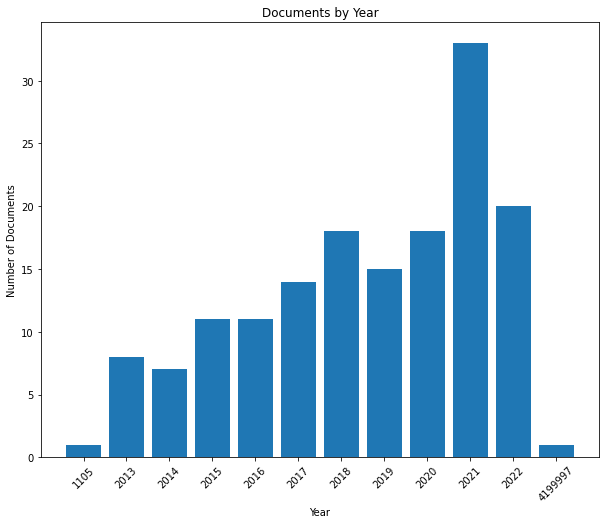

In [ ]:
plt.figure(figsize=(10,8))
plt.bar(df_art_gs['Year'], df_art_gs['Number of Articles'],align='center')
plt.title('Documents by Year')
plt.xlabel('Year')
plt.ylabel('Number of Documents')
plt.xticks(rotation=45)
plt.show();

## 2. Get a csv file from Scopus with the same column names

In this section, we will read the CSV file obtained from Scopus and modify its columns so that it matches Google Scholar DataFrame

In [ ]:
# read csv file
df_sc = pd.read_csv('scopus.csv')
print(len(df_sc))
df_sc.head()

In [ ]:
# get Scopus DataFrame column names
cols = list(df_sc.columns.values)
cols

In [ ]:
# rearrange columns
df_sc = df_sc[[cols[1], cols[2], cols[0],  cols[4], cols[3], cols[5], cols[6] ]]
# rename Scopus columns based on Google Scholar DataFrame
df_sc.columns=df_gs.columns.values
df_sc.head(1)

In [ ]:
# check if columns are the same
df_gs.columns==df_sc.columns

In [ ]:
# save DataFrame
df_sc.to_csv('df_sc.csv', index=False)

In [ ]:
df_sc = pd.read_csv('df_sc.csv')

Now, let's visualize the number of documents by year.

In [ ]:
%matplotlib inline
df_art_sc = df_sc.groupby(['Year'])[['Paper Title']].count()\
                .rename(columns={'Paper Title':'Number of Articles'}).sort_index(ascending=True).reset_index()

df_art_sc = df_art_sc.astype({"Year":'int'})
df_art_sc = df_art_sc.astype({"Year":'str'})

In [ ]:
plt.figure(figsize=(10,8))
plt.bar(df_art_sc['Year'], df_art_sc['Number of Articles'],align='center')
plt.title('Documents by Year')
plt.xlabel('Year')
plt.ylabel('Number of Documents')
plt.xticks(rotation=45)
plt.show();

## 3. Get a csv file from PubMed with the same column names

In this section, we will read the CSV file obtained from PubMed and modify its columns so that it matches Google Scholar DataFrame

In [ ]:
# read csv file
df_pm = pd.read_csv('pubmed.csv')
print(len(df_pm))
df_pm.head()

7


,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,PMCID,NIHMS ID,DOI
0,31520956,Associations of wildfire smoke PM(2.5) exposur...,"Stowell JD, Geng G, Saikawa E, Chang HH, Fu J,...",Environ Int. 2019 Dec;133(Pt A):105151. doi: 1...,Stowell JD,Environ Int,2019,2019/09/15,PMC8163094,NIHMS1699076,10.1016/j.envint.2019.105151
1,31254082,Time-series analysis of satellite-derived fine...,"Chang HH, Pan A, Lary DJ, Waller LA, Zhang L, ...",Environ Monit Assess. 2019 Jun 28;191(Suppl 2)...,Chang HH,Environ Monit Assess,2019,2019/06/30,NaN,NaN,10.1007/s10661-019-7421-4
2,31806712,Early life exposure to air pollution and incid...,"To T, Zhu J, Stieb D, Gray N, Fong I, Pinault ...",Eur Respir J. 2020 Feb 20;55(2):1900913. doi: ...,To T,Eur Respir J,2020,2019/12/07,PMC7031706,NaN,10.1183/13993003.00913-2019
3,23906969,Evaluation of a wildfire smoke forecasting sys...,"Yao J, Brauer M, Henderson SB.",Environ Health Perspect. 2013 Oct;121(10):1142...,Yao J,Environ Health Perspect,2013,2013/08/03,PMC3801470,NaN,10.1289/ehp.1306768
4,32642628,Using Satellites to Track Indicators of Global...,"Anenberg SC, Bindl M, Brauer M, Castillo JJ, C...",Geohealth. 2020 Jul 1;4(7):e2020GH000270. doi:...,Anenberg SC,Geohealth,2020,2020/07/10,PMC7334378,NaN,10.1029/2020GH000270


In [ ]:
# get PubMed DataFrame column names
colpm = list(df_pm.columns.values)
colpm

['PMID',
 'Title',
 'Authors',
 'Citation',
 'First Author',
 'Journal/Book',
 'Publication Year',
 'Create Date',
 'PMCID',
 'NIHMS ID',
 'DOI']

In [ ]:
# rearrange columns
df_pm = df_pm[[colpm[1], colpm[6], colpm[2], colpm[5], colpm[-1]]]
# add missing columns
df_pm.insert(3, "Citation", np.nan)
df_pm.insert(6, "Abstract", ' ')
# rename Scopus columns based on Google Scholar DataFrame
df_pm.columns=df_gs.columns.values
df_pm.head(1)

,Paper Title,Year,Author,Citation,Publication,Url of paper,Abstract
0,Associations of wildfire smoke PM(2.5) exposur...,2019,"Stowell JD, Geng G, Saikawa E, Chang HH, Fu J,...",NaN,Environ Int,10.1016/j.envint.2019.105151,


In [ ]:
# check if columns are the same
df_gs.columns==df_pm.columns

array([ True,  True,  True,  True,  True,  True,  True])

Now, let's visualize the number of documents by year.

In [ ]:
%matplotlib inline
df_art_pm = df_pm.groupby(['Year'])[['Paper Title']].count()\
                .rename(columns={'Paper Title':'Number of Articles'}).sort_index(ascending=True).reset_index()

df_art_pm = df_art_pm.astype({"Year":'int'})
df_art_pm = df_art_pm.astype({"Year":'str'})

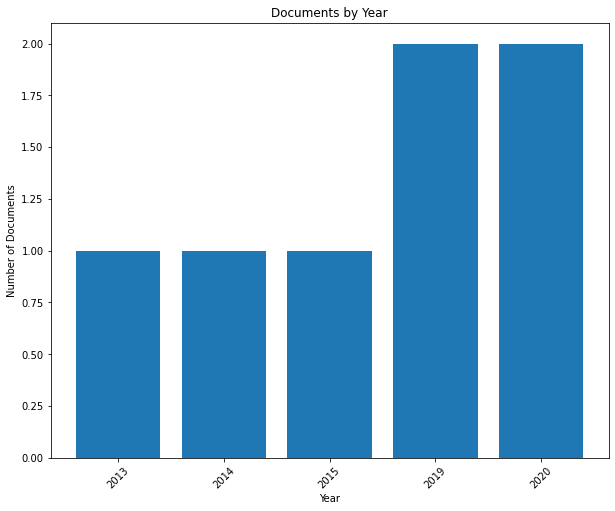

In [ ]:
plt.figure(figsize=(10,8))
plt.bar(df_art_pm['Year'], df_art_pm['Number of Articles'],align='center')
plt.title('Documents by Year')
plt.xlabel('Year')
plt.ylabel('Number of Documents')
plt.xticks(rotation=45)
plt.show();

## 4.Compare datasets to detect duplicate titles.

In this section, we will concatenate out three datasets and detect if there are duplicated articles. Finally, we will save the resulting DataFrame that will be filtered using the main research question.

In [ ]:
# concat DataFrames
df_gs_sc_pm = pd.concat([df_gs, df_sc, df_pm], ignore_index=True)

In [ ]:
df_gs_sc_pm.head()

,Paper Title,Year,Author,Citation,Publication,Url of paper,Abstract
0,Aerosol optical depth as a measure of particul...,2015.0,"G Higgs, DA Sterling, S Aryal",8.0,journals.sagepub.com,https://journals.sagepub.com/doi/abs/10.4137/E...,An understanding of human health implications ...
1,Time series analysis of fine particulate matte...,2013.0,"CT Elliott, SB Henderson, V Wan",100.0,Springer,https://link.springer.com/article/10.1186/1476...,Several studies have evaluated the association...
2,Fine particulate matter concentration and comp...,2021.0,"É Lavigne, R Talarico, A van Donkelaar",24.0,Elsevier,https://www.sciencedirect.com/science/article/...,Background Several studies have found positive...
3,Spatial Correlation of Satellite-Derived PM2.5...,2016.0,"CJ Liu, CY Liu, NT Mong, CCK Chou",22.0,mdpi.com,https://www.mdpi.com/164068,"Respiratory diseases, particularly allergic rh..."
4,HIPAA compliant wireless sensing smartwatch ap...,2016.0,"A Hosseini, CM Buonocore",24.0,ieeexplore.ieee.org,https://ieeexplore.ieee.org/abstract/document/...,Asthma is the most prevalent chronic disease a...


In [ ]:
# verify length
print(len(df_gs_sc_pm))
len(df_gs) + len(df_sc) + len(df_pm) == len(df_gs_sc_pm)

194


True

In [ ]:
# detect duplicated
duplicate = df_gs_sc_pm[df_gs_sc_pm.duplicated(['Paper Title'], keep='last')]

In [ ]:
duplicate

,Paper Title,Year,Author,Citation,Publication,Url of paper,Abstract
1,Time series analysis of fine particulate matte...,2013.0,"CT Elliott, SB Henderson, V Wan",100.0,Springer,https://link.springer.com/article/10.1186/1476...,Several studies have evaluated the association...
69,Predicting high-resolution spatial and tempora...,2022.0,T Okome,0.0,escholarship.mcgill.ca,https://escholarship.mcgill.ca/concern/theses/...,Background: Scientists expect climate change t...
167,"[PDF][PDF] Stadtbäume: Wachstum, Funktionen un...",2018.0,"A Moser, T Rötzer, S Pauleit",11.0,waldwachstum.wzw.tum.de,https://www.waldwachstum.wzw.tum.de/fileadmin/...,Als Folge der Urbanisierung steigt die Zahl de...
172,Using Satellites to Track Indicators of Global...,2020.0,"Anenberg S.C., Bindl M., Brauer M., Castillo J...",12.0,GeoHealth,https://www.scopus.com/inward/record.uri?eid=2...,The 2018 NASA Health and Air Quality Applied S...
174,Early life exposure to air pollution and incid...,2020.0,"To T., Zhu J., Stieb D., Gray N., Fong I., Pin...",52.0,European Respiratory Journal,https://www.scopus.com/inward/record.uri?eid=2...,Rationale: There is growing evidence that air ...
178,Time-series analysis of satellite-derived fine...,2019.0,"Chang H.H., Pan A., Lary D.J., Waller L.A., Zh...",10.0,Environmental Monitoring and Assessment,https://www.scopus.com/inward/record.uri?eid=2...,In order to examine associations between asthm...
184,An empirical model to estimate daily forest fi...,2014.0,"Yao J., Henderson S.B.",39.0,Journal of Exposure Science and Environmental ...,https://www.scopus.com/inward/record.uri?eid=2...,Exposure to forest fire smoke (FFS) is associa...
185,Evaluation of a wildfire smoke forecasting sys...,2013.0,"Yao J., Brauer M., Henderson S.B.",43.0,Environmental Health Perspectives,https://www.scopus.com/inward/record.uri?eid=2...,Background: Exposure to wildfire smoke has bee...


In [ ]:
len(duplicate)

8

In [ ]:
# drop dulicates and preserve the last one
df_gs_sc_pm_2 = df_gs_sc_pm.drop_duplicates(subset=['Paper Title'], keep='last')
df_gs_sc_pm_2.head()

,Paper Title,Year,Author,Citation,Publication,Url of paper,Abstract
0,Aerosol optical depth as a measure of particul...,2015.0,"G Higgs, DA Sterling, S Aryal",8.0,journals.sagepub.com,https://journals.sagepub.com/doi/abs/10.4137/E...,An understanding of human health implications ...
2,Fine particulate matter concentration and comp...,2021.0,"É Lavigne, R Talarico, A van Donkelaar",24.0,Elsevier,https://www.sciencedirect.com/science/article/...,Background Several studies have found positive...
3,Spatial Correlation of Satellite-Derived PM2.5...,2016.0,"CJ Liu, CY Liu, NT Mong, CCK Chou",22.0,mdpi.com,https://www.mdpi.com/164068,"Respiratory diseases, particularly allergic rh..."
4,HIPAA compliant wireless sensing smartwatch ap...,2016.0,"A Hosseini, CM Buonocore",24.0,ieeexplore.ieee.org,https://ieeexplore.ieee.org/abstract/document/...,Asthma is the most prevalent chronic disease a...
5,[PDF][PDF] Association between climate variabl...,2017.0,"A de Souza, DA da Silva Santos",7.0,.emnuvens.com.br,https://revistamundodasaude.emnuvens.com.br/mu...,Many studies have shown that climatic and poll...


In [ ]:
# verify if there is any duplicate
duplicate = df_gs_sc_pm_2[df_gs_sc_pm_2.duplicated(['Paper Title'])]
duplicate

,Paper Title,Year,Author,Citation,Publication,Url of paper,Abstract


In [ ]:
# 194-8 = 186
len(df_gs_sc_pm_2)

186

Now, let's visualize the number of documents by year in the filtered dataframe.

In [ ]:
%matplotlib inline
df_art_gs_sc_pm = df_gs_sc_pm_2 .groupby(['Year'])[['Paper Title']].count()\
                .rename(columns={'Paper Title':'Number of Articles'}).sort_index(ascending=True).reset_index()

df_art_gs_sc_pm = df_art_gs_sc_pm.astype({"Year":'int'})
df_art_gs_sc_pm = df_art_gs_sc_pm.astype({"Year":'str'})

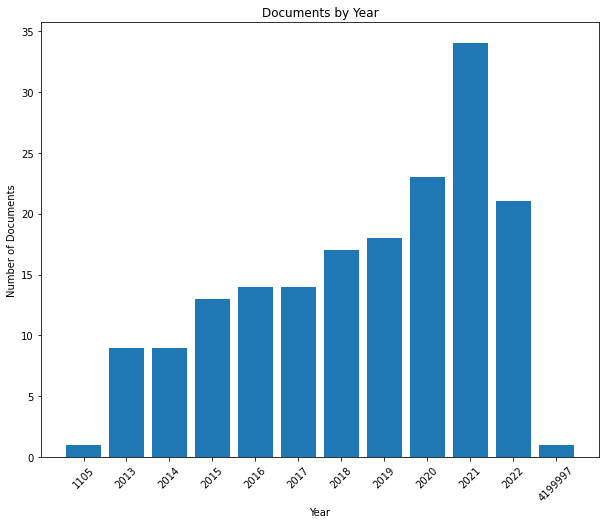

In [ ]:
plt.figure(figsize=(10,8))
plt.bar(df_art_gs_sc_pm['Year'], df_art_gs_sc_pm['Number of Articles'],align='center')
plt.title('Documents by Year')
plt.xlabel('Year')
plt.ylabel('Number of Documents')
plt.xticks(rotation=45)
plt.show();

In [ ]:
# save DataFrame
df_gs_sc_pm_2.to_csv('df_gs_sc_pm.csv', index=False)

## 5. Reading title and abstract and answering the main research question.

In this section, we will read the title and abstract of each article and try to answer the main research question. Those articles that meet the main question will be selected. To do that we will better visualize the DataFrame using `data table notebook`, then we will create a new column named `decision`where will mark if `accepted (1) rejected (0)`. The final filtered dataset will be used for subsequent querying in order to build our review article.

In [ ]:
import pandas as pd
import ipywidgets as widgets

In [ ]:
#
index = 0

In [ ]:
# open DataFrame
df_gs_sc_pm = pd.read_csv('df_gs_sc_pm.csv')
df_gs_sc_pm.iloc[[index]]

,Paper Title,Year,Author,Citation,Publication,Url of paper,Abstract,Desicion
0,Aerosol optical depth as a measure of particul...,2015.0,"G Higgs, DA Sterling, S Aryal",8.0,journals.sagepub.com,https://journals.sagepub.com/doi/abs/10.4137/E...,An understanding of human health implications ...,1.0


In [ ]:
# seach for something
#df_gs_sc_pm[df_gs_sc_pm['Paper Title'].str.contains("Aerosol optical", na=False)]
len(df_gs_sc_pm[df_gs_sc_pm['Desicion'] == 1.0])

59

In [ ]:
# add column
#df_gs_sc_pm['Desicion'] = pd.NaT

### Does the article study Asthma?

In [ ]:
# options
option_lst = ['Yes', 'No']

# dropdown list for asthma
asthma = widgets.Dropdown(
    options= option_lst,
    value='Yes')

print('Select an option for asthma')
display(asthma)

Select an option for asthma


Dropdown(options=('Yes', 'No'), value='Yes')

In [ ]:
asthma.value

'No'

### Does the article study Allergic Rhinitis?

---



In [ ]:
# options
option_lst = ['Yes', 'No']

# dropdown list for allergic rhinitis
ar = widgets.Dropdown(
    options= option_lst,
    value='Yes')

print('Select an option for allergic rhinitis')
display(ar)

Select an option for allergic rhinitis


Dropdown(options=('Yes', 'No'), value='Yes')

In [ ]:
ar.value

'No'

### Does the article use Air Quality data?

In [ ]:
# options
option_lst = ['Yes', 'No']

# dropdown list for air quality
aq = widgets.Dropdown(
    options= option_lst,
    value='Yes')

print('Select an option for air quality')
display(aq)

Select an option for air quality


Dropdown(options=('Yes', 'No'), value='Yes')

In [ ]:
aq.value

'Yes'

### Does the article use Remote Sensing data?

In [ ]:
# options
option_lst = ['Yes', 'No']

# dropdown list for remote sensing
rs = widgets.Dropdown(
    options= option_lst,
    value='Yes')

print('Select an option for remote sensing')
display(rs)

Select an option for remote sensing


Dropdown(options=('Yes', 'No'), value='Yes')

In [ ]:
rs.value

'Yes'

In [ ]:
# use if and elif statements to accept the paper
if asthma.value == 'Yes' and rs.value == 'Yes' and aq.value == 'Yes':
  df_gs_sc_pm.at[index, 'Desicion'] = 1 # accepted
elif ar.value == 'Yes' and rs.value == 'Yes' and aq.value == 'Yes':
  df_gs_sc_pm.at[index, 'Desicion'] = 1 # accepted
else:
  df_gs_sc_pm.at[index, 'Desicion'] = 0 # rejected

In [ ]:
# checking results
df_gs_sc_pm.iloc[index]

Paper Title     An empirical model to estimate daily forest fi...
Year                                                       2014.0
Author                                       Yao J, Henderson SB.
Citation                                                      NaN
Publication                          J Expo Sci Environ Epidemiol
Url of paper                                  10.1038/jes.2013.87
Abstract                                                         
Desicion                                                      0.0
Name: 185, dtype: object

In [ ]:
# save changes
df_gs_sc_pm.to_csv('df_gs_sc_pm.csv', index=False)